# Latent space exploration

In this notebook we will analyze latent features obtained with the VAE+PCA model.

Required imports

In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle as pk

from helio.helio import FilesIndex, HelioBatch, BatchSampler
from helio.helio.models import VAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loading the VAE model

In [2]:
net = VAE(in_channels=1,
    filters_enc=[16, 24, 32, 64],
    filters_dec=[48, 32, 24, 16],
    z_dim=16,
    output=dict(layout='c', filters=1),
    norm=True,
    variational=True).to(device)
net.load_state_dict(torch.load('model_dumps/vae'))

<All keys matched successfully>

Loading the PCA model

In [3]:
pca = pk.load(open("model_dumps/pca.pkl",'rb'))

Let's prepare a function that will decode images for various values of latent parameters. Specifically, we select two latent parameters (`i` and `j`) and vary them in ranges
`i_range` and `j_range` correspondingly. All other latent parameters are set to zero. The function applies the inverse PCA transformation, then the VAE decoder and returns the decoded images:

In [4]:
def make_samples(i, j, i_range, j_range, net, pca):
    net = net.eval()
    with torch.no_grad():
        z = np.zeros((len(i_range), len(j_range), pca.components_.shape[0]))
        z[:, :, [i-1, j-1]] = np.array(np.meshgrid(i_range, j_range)).T
        z = z.reshape(-1, z.shape[-1])
        t = pca.inverse_transform(z)
        inp = torch.tensor(t).to(device).float()
        inp = inp.reshape(t.shape[0], 16, 16, 16)
        y = net.decode(inp)
    return y.detach().cpu().numpy()

### Z1 and Z2

Consider the latent parameters Z1 and Z2 and let's vary Z1 between -20 and 20, while Z2 is varied between -5 to 5. Plot the decoded images:

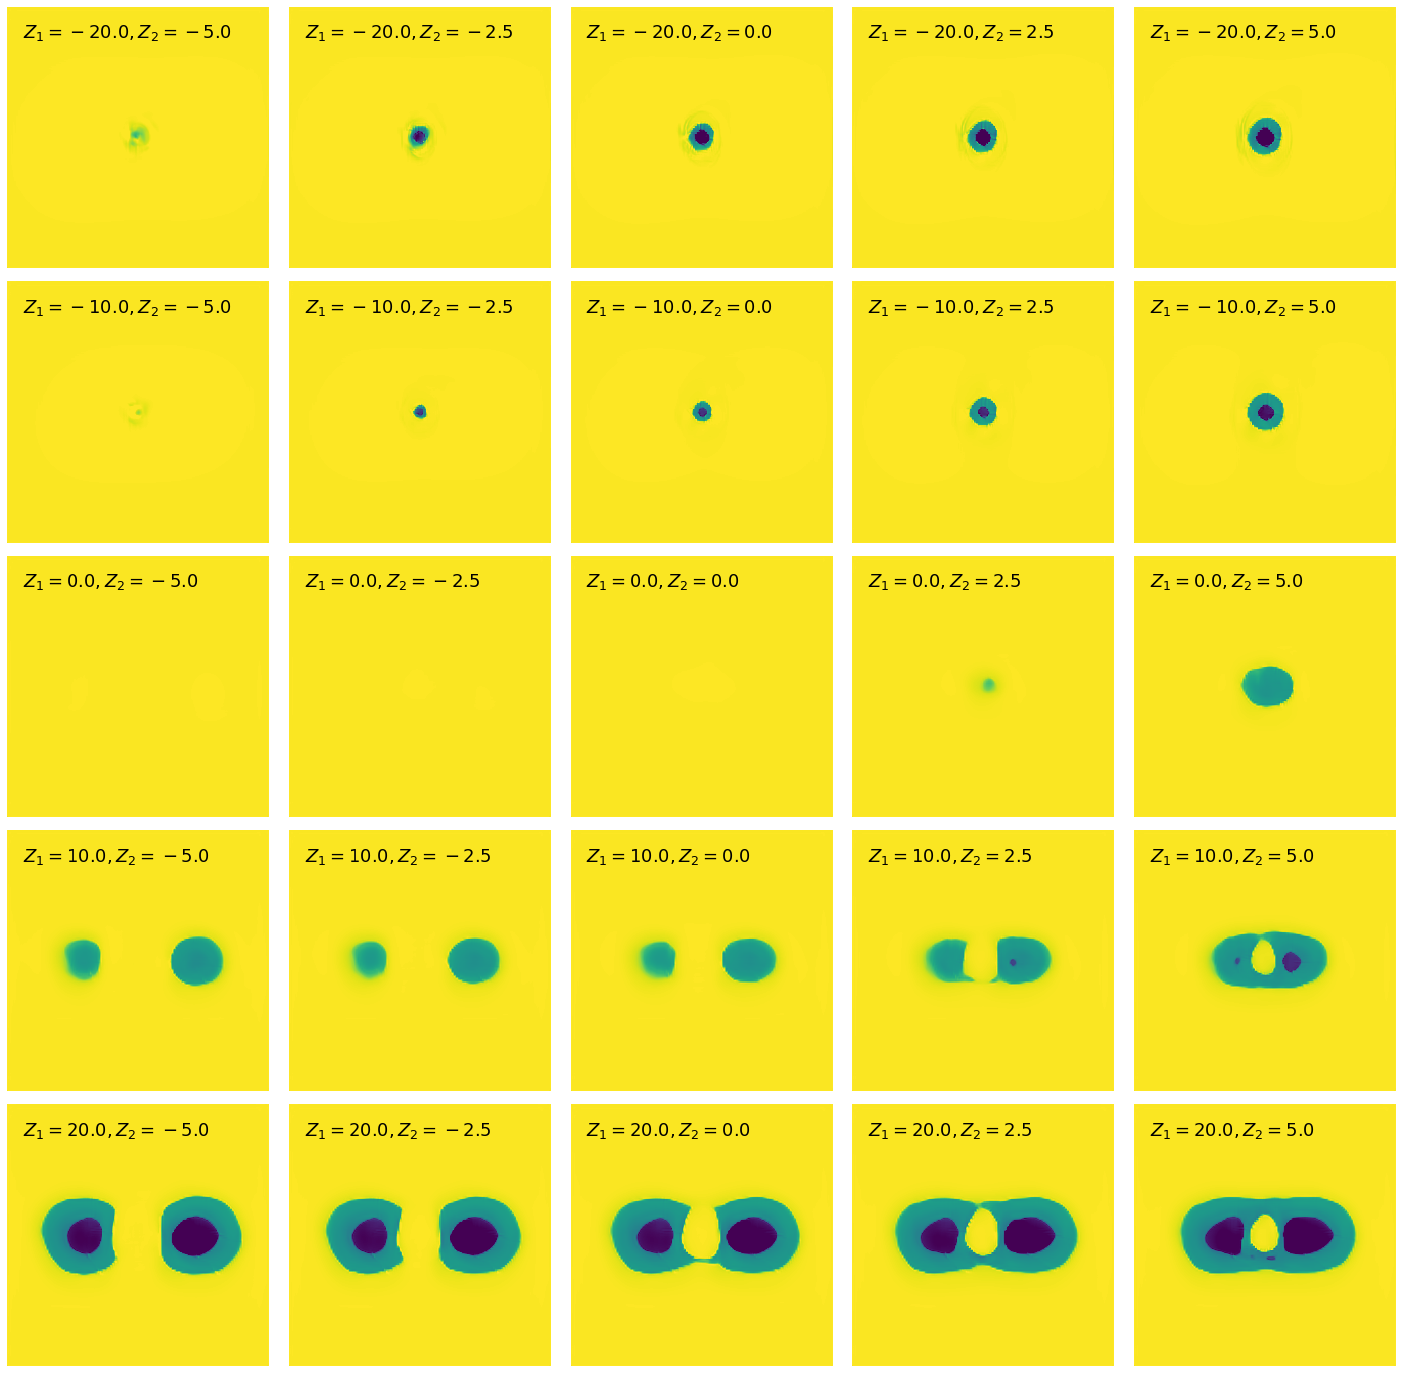

In [5]:
rows = 5
cols = 5

i = 1
j = 2
i_range = np.linspace(-20, 20, rows)
j_range = np.linspace(-5, 5, cols)
samples = make_samples(i, j, i_range, j_range, net, pca)

fig, ax = plt.subplots(rows, cols, figsize=(5*rows, 5*cols))
fig.patch.set_facecolor('xkcd:white')
for r in range(rows):
    for c in range(cols):
        ax[r, c].imshow(1-samples[r*cols+c, 0], vmin=0, vmax=1)
        ax[r, c].axis(False)
        ax[r, c].text(15, 30,
                      r'$Z_{}={}, Z_{}={}$'.format(i, i_range[r], j, j_range[c]),
                      size=18)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

We find that Z1 defines the unipolar or bipolar structure, while Z2 defines the size of the sunspot group.

### Z1 and Z5

Now we consider the latent parameters Z1 and Z5 and plot the decoded images:

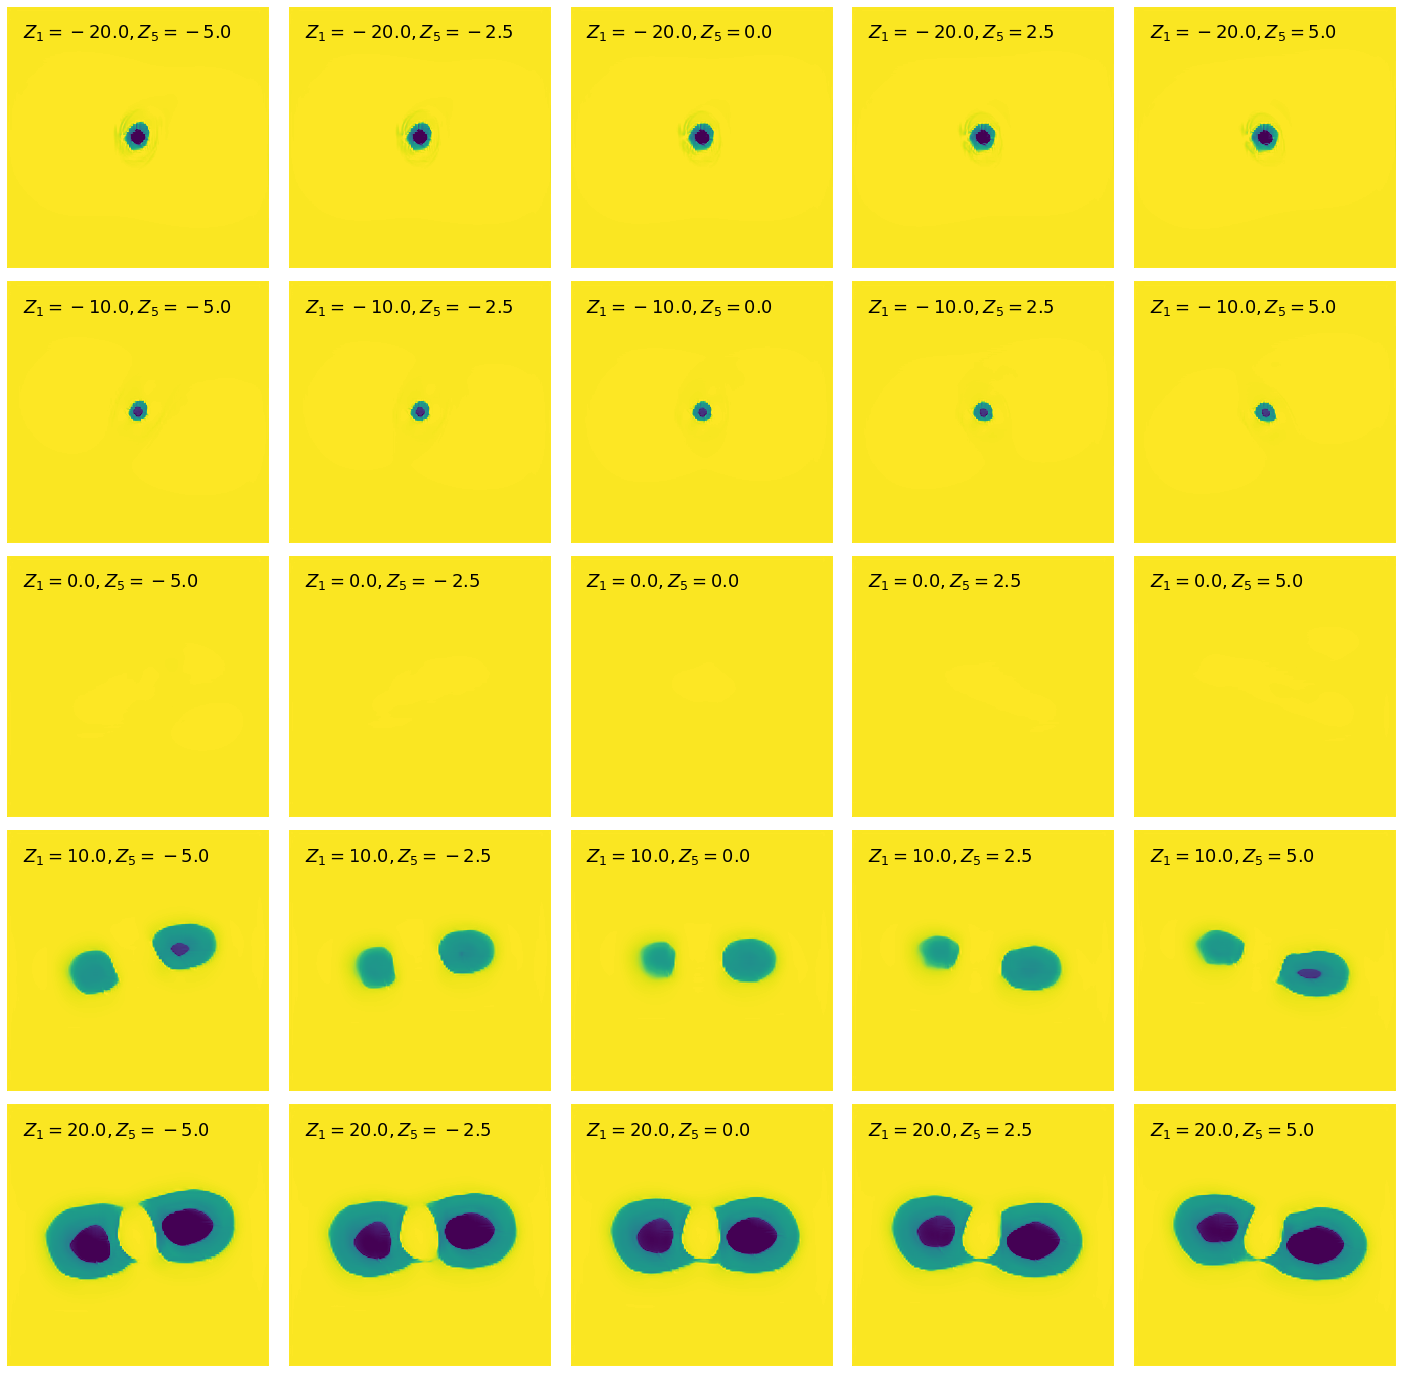

In [6]:
i = 1
j = 5
i_range = np.linspace(-20, 20, rows)
j_range = np.linspace(-5, 5, cols)
samples = make_samples(i, j, i_range, j_range, net, pca)

fig, ax = plt.subplots(rows, cols, figsize=(5*rows, 5*cols))
fig.patch.set_facecolor('xkcd:white')
for r in range(rows):
    for c in range(cols):
        ax[r, c].imshow(1-samples[r*cols+c, 0], vmin=0, vmax=1)
        ax[r, c].axis(False)
        ax[r, c].text(15, 30,
                      r'$Z_{}={}, Z_{}={}$'.format(i, i_range[r], j, j_range[c]),
                      size=18)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

One can observe that Z5 is responsible for the tilt angle of the group.

### Z1 and Z9

One more interesting observation  is related to  the latent parameter Z9:

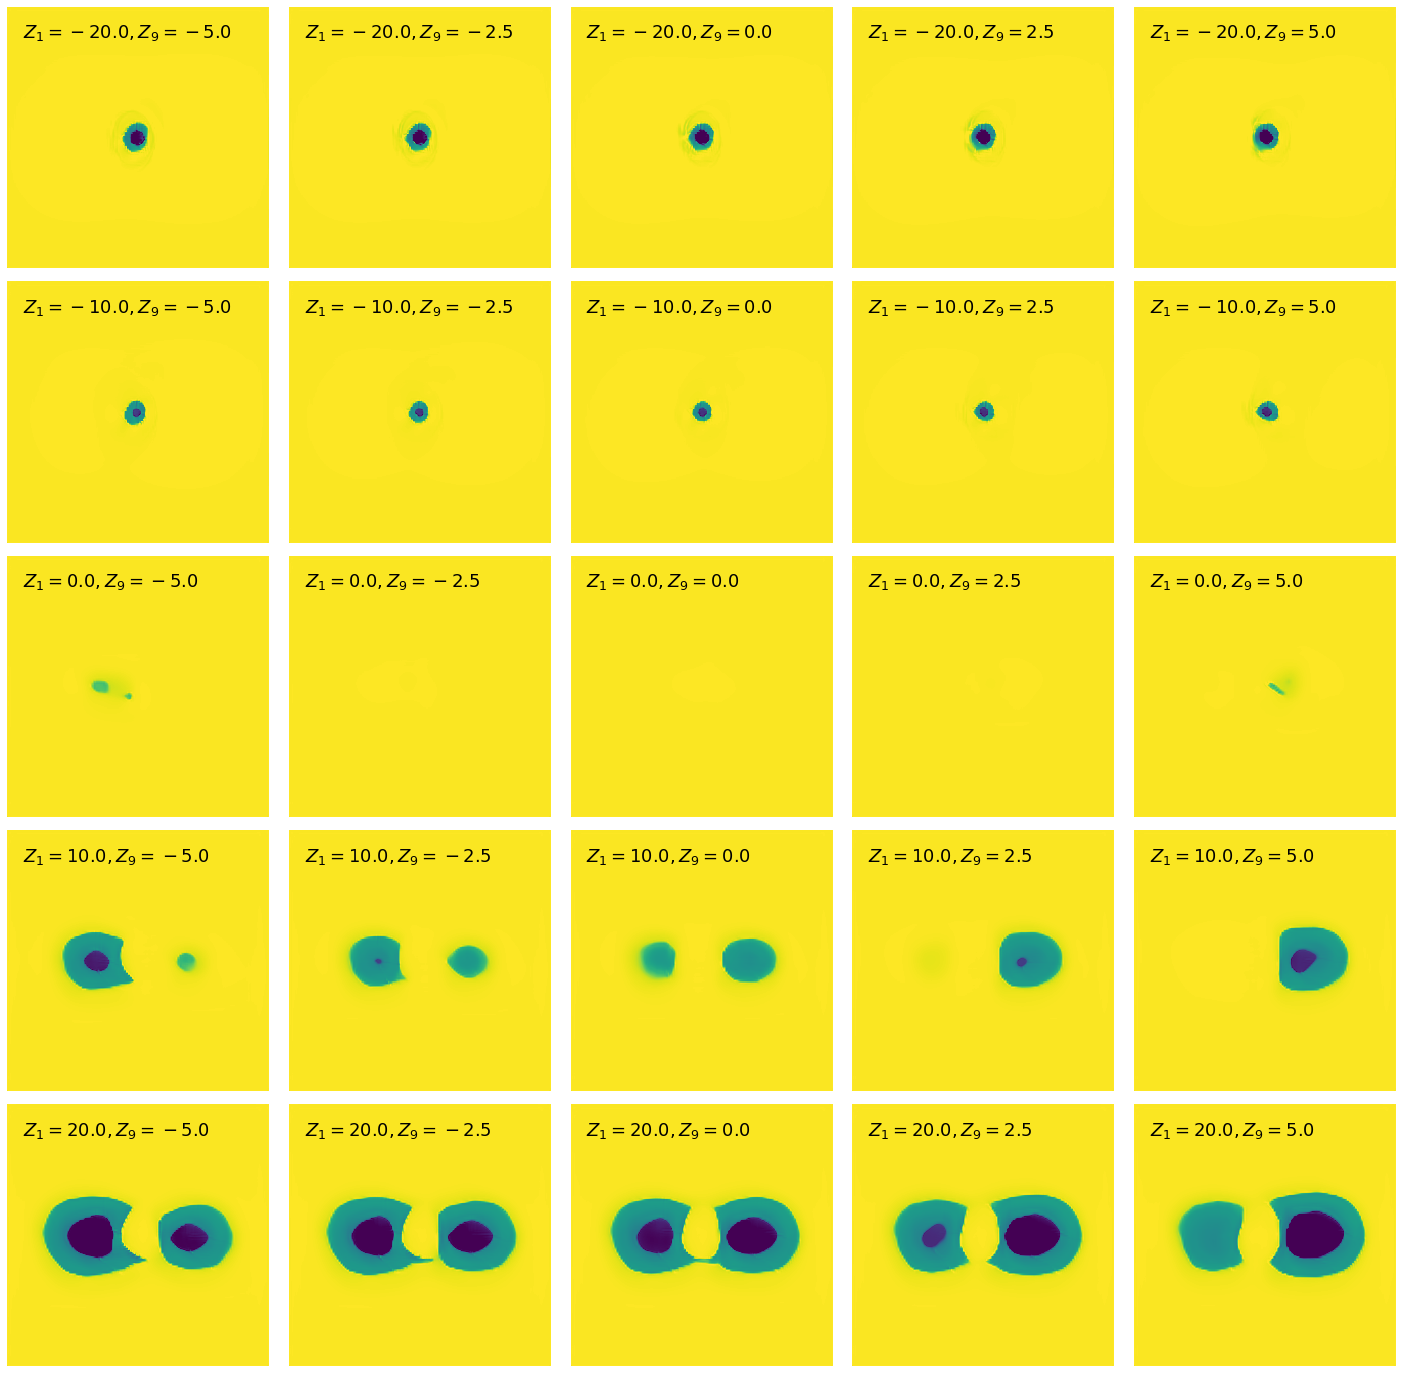

In [7]:
i = 1
j = 9
i_range = np.linspace(-20, 20, rows)
j_range = np.linspace(-5, 5, cols)
samples = make_samples(i, j, i_range, j_range, net, pca)

fig, ax = plt.subplots(rows, cols, figsize=(5*rows, 5*cols))
fig.patch.set_facecolor('xkcd:white')
for r in range(rows):
    for c in range(cols):
        ax[r, c].imshow(1-samples[r*cols+c, 0], vmin=0, vmax=1)
        ax[r, c].axis(False)
        ax[r, c].text(15, 30,
                      r'$Z_{}={}, Z_{}={}$'.format(i, i_range[r], j, j_range[c]),
                      size=18)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

One can conclude that Z9 defines a ratio between two spots in the bipolar group.

## Physical properties

Now we consider latent vectors of sunspot groups and relate them with physical properties of sunspot group. First we load sunspot group properties:

In [8]:
dfp = pd.read_csv('../dataset/sunspot_group_properties.csv').set_index('fname')
dfp.head()

,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,nspots,ncores,nspots_with_cores,tilt,complexity,B0,L0
fname,,,,,,,,,,,,,,,,
201007230452_63,2010-07-23,63,-20.896839,-23.565131,-26.597699,204.043367,200.328655,194.646751,489.292797,17,16,6,-2.385188,210,5.0,230.3
201007240414_63,2010-07-24,63,-21.131845,-23.933526,-27.108871,204.704703,201.274268,194.511357,303.408179,9,4,3,-23.918642,241,5.1,217.4
201007250447_64,2010-07-25,64,23.580196,23.339903,23.101008,149.500812,149.048761,148.527835,16.553683,1,0,0,3.633730,78,5.2,203.9
201007250447_63,2010-07-25,63,-20.642013,-23.509269,-26.938974,204.949343,201.557542,195.071475,297.469260,12,7,3,-32.418379,232,5.2,203.9
201007260349_63,2010-07-26,63,-20.258757,-23.032369,-26.887540,205.544796,202.530956,198.138547,193.869511,9,3,2,-40.638848,255,5.0,191.2


Note the full list of properties:

In [9]:
dfp.columns

Index(['date', 'group_number', 'lat_max', 'lat_mean', 'lat_min', 'long_max',
       'long_mean', 'long_min', 'area', 'nspots', 'ncores',
       'nspots_with_cores', 'tilt', 'complexity', 'B0', 'L0'],
      dtype='object')

Then we load latent vectors:

In [10]:
dfv = pd.read_csv('../latent_vectors/latent_vectors.csv').set_index('fname')
dfv.head()

,0,1,2,3,4,5,6,7,8,9,...,275,276,277,278,279,280,281,282,283,284
fname,,,,,,,,,,,,,,,,,,,,,
201007230452_63,5.817159,2.393544,2.298298,-2.580430,0.440923,1.170425,-0.932345,-0.843630,2.353555,-1.087119,...,0.067700,-0.331984,-0.417061,-0.455711,0.403591,0.152402,-0.591062,0.013325,0.394216,0.102593
201007240414_63,4.516954,-1.273279,1.670814,0.554014,-0.367154,1.088880,-3.339716,-2.285891,1.639328,-0.747262,...,-0.001624,0.462813,-0.286202,-0.161725,0.923522,0.619180,-0.296067,0.516653,0.082084,-0.134952
201007250447_64,-3.562359,-1.591547,0.735106,-0.653533,-0.042791,0.223492,-0.181523,0.536766,0.399867,0.674094,...,-0.003120,-0.007647,-0.011317,0.030441,0.012911,0.010067,-0.022198,0.028209,-0.011697,-0.005320
201007250447_63,5.481904,-0.013085,0.421038,1.029071,-3.885544,0.047404,-1.167155,-0.282734,-0.693437,0.674781,...,0.198498,0.558087,-0.051235,0.146031,0.741500,-0.384267,-0.291666,0.512452,0.228842,0.676496
201007260349_63,-0.748889,0.498187,1.556057,0.578482,-3.790440,1.909326,-0.237615,-1.284559,1.739071,-0.362990,...,-0.469999,0.040401,0.104927,0.641592,-0.067677,-0.681371,0.523195,-0.064146,-0.245792,0.265645


Merge both tables:

In [11]:
df = dfp.join(dfv)
df.head()

,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,nspots,...,275,276,277,278,279,280,281,282,283,284
fname,,,,,,,,,,,,,,,,,,,,,
201007230452_63,2010-07-23,63,-20.896839,-23.565131,-26.597699,204.043367,200.328655,194.646751,489.292797,17,...,0.067700,-0.331984,-0.417061,-0.455711,0.403591,0.152402,-0.591062,0.013325,0.394216,0.102593
201007240414_63,2010-07-24,63,-21.131845,-23.933526,-27.108871,204.704703,201.274268,194.511357,303.408179,9,...,-0.001624,0.462813,-0.286202,-0.161725,0.923522,0.619180,-0.296067,0.516653,0.082084,-0.134952
201007250447_64,2010-07-25,64,23.580196,23.339903,23.101008,149.500812,149.048761,148.527835,16.553683,1,...,-0.003120,-0.007647,-0.011317,0.030441,0.012911,0.010067,-0.022198,0.028209,-0.011697,-0.005320
201007250447_63,2010-07-25,63,-20.642013,-23.509269,-26.938974,204.949343,201.557542,195.071475,297.469260,12,...,0.198498,0.558087,-0.051235,0.146031,0.741500,-0.384267,-0.291666,0.512452,0.228842,0.676496
201007260349_63,2010-07-26,63,-20.258757,-23.032369,-26.887540,205.544796,202.530956,198.138547,193.869511,9,...,-0.469999,0.040401,0.104927,0.641592,-0.067677,-0.681371,0.523195,-0.064146,-0.245792,0.265645


Now let's plot a distribution of Z1 over single-spot and multi-spot groups:

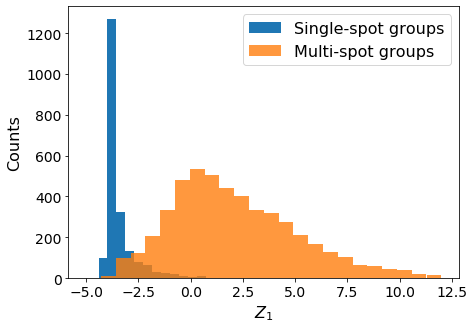

In [12]:
fig, ax = plt.subplots(1, figsize=(7, 5))
fig.patch.set_facecolor('xkcd:white')

mask = (df.nspots == 1) & (df.ncores >= 1)
plt.hist(df.loc[mask, '0'], bins=30, color='tab:blue', label='Single-spot groups')

mask = (dfp.nspots >= 2) & (dfp.ncores >= 2)
plt.hist(df.loc[mask, '0'], bins=np.linspace(-5, 12, 25),
         color='tab:orange', alpha=0.8, label='Multi-spot groups')

plt.ylabel('Counts', fontsize=16)
plt.xlabel(r'$Z_1$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

The above plot confirms the interpretation of Z1. As we can see, Z1 separates single-spot and multi-spot groups.

In the next plot we demonstrate the distribution of sunspot group area in the space of latent variables Z1 and Z2:

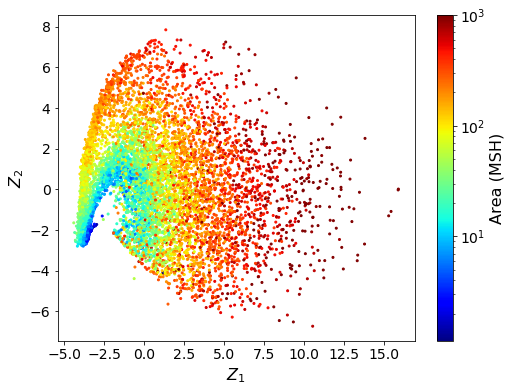

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 6))
fig.patch.set_facecolor('xkcd:white')

plt.scatter(*df[['0', '1']].values.T, s=4,
            cmap='jet',
            c=np.clip(df.area, 0, 1000),
            norm=matplotlib.colors.LogNorm())

plt.ylabel(r'$Z_2$', fontsize=16)
plt.xlabel(r'$Z_1$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'Area (MSH)', rotation=90, fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.show()

Done! We have demonstrated basic examples of latent space exploration and hope it will motivate further research!